### Import libraries

In [62]:
import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from IPython.display import HTML, display, SVG
from IPython.core import display as ICD
from plotly.offline import init_notebook_mode, iplot

import math
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.regularizers import L1L2
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import model_to_dot

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import svm
from sklearn import tree
from sklearn import neighbors
from sklearn import linear_model

import nltk
import string
from nltk.stem import WordNetLemmatizer, SnowballStemmer

import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)

In [59]:
def batch_generator_shuffle(X_data, y_data, batch_size):
    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter=0
    index = np.arange(np.shape(y_data)[0])
    np.random.shuffle(index)
    while 1:
        index_batch = index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X_data[index_batch,:]
        y_batch = y_data[index_batch]
        counter += 1
        yield X_batch,y_batch
        if (counter > number_of_batches):
            np.random.shuffle(index)
            counter=0

In [60]:
def as_keras_metric(method):
    import functools
    from keras import backend as K
    import tensorflow as tf
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

@as_keras_metric
def auc_pr(y_true, y_pred, curve='PR'):
    return tf.metrics.auc(y_true, y_pred, curve=curve)

In [3]:
seed = 13
stemmer = SnowballStemmer("english")
lemma = WordNetLemmatizer()

le = LabelEncoder()

In [4]:
SOURCE_FOLDER = 'dataset/'
OUTPUT_FOLDER = 'Models_and_output/'

In [5]:
train_data = pd.read_csv(SOURCE_FOLDER + 'train.csv', encoding='ISO-8859-1')
test_data = pd.read_csv(SOURCE_FOLDER + 'test.csv', encoding='utf8')
test_data = test_data[test_data.columns[1:-1]]

In [7]:
train_data = train_data[train_data['TRANS_CONV_TEXT'].notnull()]

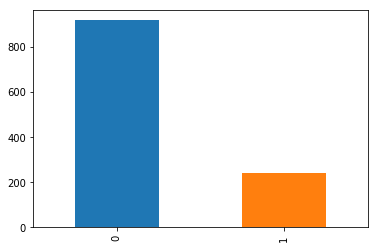

In [8]:
le.fit(train_data.Source)
train_source = le.transform(train_data.Source)

train_data.Patient_Tag.value_counts().plot('bar')

In [9]:
X_train = train_data['TRANS_CONV_TEXT']
Y_train = train_data['Patient_Tag']
Y_train = to_categorical(Y_train)

In [10]:
def preprocess_data(X_train, stemmer, lemma):
    preprocessed_data = []
    trans = str.maketrans('/(){}', ' ' * 5)
    trans_punc = str.maketrans('', '', string.punctuation)

    for text in X_train:
        text = text.lower().translate(trans)
        text = text.translate(trans_punc)
        text = [lemma.lemmatize(word) for word in text.split()]
        preprocessed_data.append(' '.join(text))

    return preprocessed_data

In [11]:
preprocessed_data = preprocess_data(X_train, stemmer, lemma)

In [28]:
preprocessed_data[-1]

'i went through a sleep study ahi severe at 95 and titration test in late 2011 but wa never able to sleep effectively i own the system one series 50 650 bipap pro that i wa prescribed and an opus 360 nasal pillow assembly both are essentially unused im about 20 pound lighter than i wa back then and my sleeping seems to be a little bit better now than it wa back then whats the best way of trying to address my sleep apnea again is it ok to just try my existing machine and setting and adjust using sleepyhead do i need to go back to the doc and or do another sleep study are there any particularly good mask since 2011 that might be better than what i have ive spent the last three week dealing with a father with congestive heart failure and id like to try and do what i can to avoid that'

In [17]:
t = Tokenizer()
t.fit_on_texts(preprocessed_data)
encoded_lines = t.texts_to_sequences(preprocessed_data)

In [64]:
number_of_words = len(t.word_index) + 1
max_length_of_input = 1000
embedding_vector_length = 32

In [65]:
X_train = sequence.pad_sequences(encoded_lines, max_length_of_input)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=0.33, random_state=seed)

In [66]:
model = Sequential()
model.add(Embedding(number_of_words, embedding_vector_length, input_length = max_length_of_input))
# Uncomment the below line if you want to use Dropout
# model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(2, activation = 'softmax'))

In [68]:
precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[auc_pr, 'accuracy'])

mc = keras.callbacks.ModelCheckpoint('weights{epoch:08d}.h5', 
                                     save_weights_only=True, period=5)

# Try 40 epochs
model.fit_generator(generator=batch_generator_shuffle(X_train, y_train, 32),
                      epochs=6, validation_data=(X_valid, y_valid),
                      steps_per_epoch=X_train.shape[0] / 32, callbacks=[mc])

scores = model.evaluate(X_valid, y_valid)
print ('\n')
print (scores)

Epoch 1/6
25/24 [===============================] - 21s 860ms/step - loss: 0.0020 - auc_pr: 0.9599 - acc: 1.0000 - val_loss: 0.8783 - val_auc_pr: 0.9856 - val_acc: 0.8796
Epoch 2/6
25/24 [===============================] - 20s 806ms/step - loss: 7.2443e-05 - auc_pr: 0.9811 - acc: 1.0000 - val_loss: 0.7238 - val_auc_pr: 0.9814 - val_acc: 0.9005
Epoch 3/6
25/24 [===============================] - 21s 852ms/step - loss: 3.0398e-05 - auc_pr: 0.9809 - acc: 1.0000 - val_loss: 0.7544 - val_auc_pr: 0.9807 - val_acc: 0.8979
Epoch 4/6
25/24 [===============================] - 20s 797ms/step - loss: 2.2041e-05 - auc_pr: 0.9805 - acc: 1.0000 - val_loss: 0.8168 - val_auc_pr: 0.9804 - val_acc: 0.8770
Epoch 5/6
25/24 [===============================] - 20s 791ms/step - loss: 1.9127e-05 - auc_pr: 0.9802 - acc: 1.0000 - val_loss: 0.8542 - val_auc_pr: 0.9801 - val_acc: 0.8743
Epoch 6/6
382/382 [==============================] - 2s 5ms/step


[0.8538091270087277, 0.9776763326210501, 0.8795811502721297]


1 - 7: val_loss: 0.3521 - val_auc_pr: 0.9775 - val_acc: 0.8922
2 - 200: val_loss: 0.6366 - val_auc_pr: 0.9851 - val_acc: 0.8889
3 - val_loss: 1.3443 - val_auc_pr: 0.9714 - val_acc: 0.8246

[0.626494295846403, 0.983139782170065, 0.8856209134743884]

In [71]:
X_test = test_data['TRANS_CONV_TEXT']
X_test = preprocess_data(X_test, stemmer, lemma)
X_test = t.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test, max_length_of_input)

In [78]:
X_test

array([[   0,    0,    0, ..., 3934,  743,  982],
       [   0,    0,    0, ...,  929,  395,  176],
       [   0,    0,    0, ..., 7374, 7375, 4014],
       ...,
       [   0,    0,    0, ...,  114,  296,   35],
       [   0,    0,    0, ...,   68,   12,    7],
       [   0,    0,    0, ...,   26,  172,  668]], dtype=int32)

In [76]:
output = model.predict(X_test, 32)

patient_tag = np.argmax(output, axis=1)
index = list(range(1, len(output)+1))
test_data_df = pd.DataFrame({'Index': index,'Patient_Tag': patient_tag}).set_index('Index')
test_data_df.to_csv('output.csv', columns=['Patient_Tag'] )

In [103]:
test_data_df.Patient_Tag.value_counts()

0    470
1    101
Name: Patient_Tag, dtype: int64

In [104]:
model_json = model.to_json()
with open(OUTPUT_FOLDER + "6_model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights(OUTPUT_FOLDER + "6_model.h5")

In [102]:
# out1 = pd.read_csv('Models_and_output/3_output_85_11384.csv')
# out1.Patient_Tag.value_counts()